## Run Regressions on Generated Factors

## Load Processed Data

In [1]:
import pandas as pd 
from utils import *
import os

# load data
DATA_DIR = os.path.abspath("../../data/processed")

sage_factors = pd.read_csv(os.path.join(DATA_DIR, "sage_factors.csv"))
uniqueness = pd.read_csv(os.path.join(DATA_DIR, "uniqueness.csv"))
mod_ind_momentum = pd.read_csv(os.path.join(DATA_DIR, "mod_ind_momentum.csv"))
residualized_short_interest = pd.read_csv(os.path.join(DATA_DIR, "residualized_short_interest.csv"))

## Merge Data

In [2]:
# standardize date columns
sage_factors["MONTH_END"] = pd.to_datetime(sage_factors["MONTH_END"]) + pd.offsets.MonthEnd(0)
uniqueness["MONTH_END"] = pd.to_datetime(uniqueness["MONTH_END"]) + pd.offsets.MonthEnd(0)
mod_ind_momentum["MONTH_END"] = pd.to_datetime(mod_ind_momentum["MONTH_END"]) + pd.offsets.MonthEnd(0)
residualized_short_interest["MONTH_END"] = pd.to_datetime(residualized_short_interest["MONTH_END"]) + pd.offsets.MonthEnd(0)

# merge data
data = pd.merge(sage_factors, uniqueness, on=["COMPANY_ID", "MONTH_END"], how="left").reset_index(drop=True)
data = pd.merge(data, mod_ind_momentum, on=["COMPANY_ID", "MONTH_END"], how="left").reset_index(drop=True)
data = pd.merge(data, residualized_short_interest, on=["COMPANY_ID", "MONTH_END"], how="left").reset_index(drop=True)

# get column names for each momentum window combination 
window_sizes = [3, 6, 12, 24, 48]
momentum_columns = [f'avg_modality_momentum_{window}m' for window in window_sizes] + [f'avg_indication_momentum_{window}m' for window in window_sizes]

data = data.dropna(subset=["uniqueness"] + momentum_columns)
data.columns = [col.lower() for col in data.columns]

In [4]:
print(data.shape)
print(data.head(10).to_markdown(index=False))
assert(data.shape == (104506, 29))

(104506, 29)
| month_end           |   company_id |   excess_return_usd_ln |   excess_return_usd |   quality |     value |   coverage |    momentum |      size |   earnings_volatility |      growth |   trading_activity |   leverage |   volatility |   short_interest |   short_interest_pct_float | reg_group   |   uniqueness |   avg_modality_momentum_3m |   avg_modality_momentum_6m |   avg_modality_momentum_12m |   avg_modality_momentum_24m |   avg_modality_momentum_48m |   avg_indication_momentum_3m |   avg_indication_momentum_6m |   avg_indication_momentum_12m |   avg_indication_momentum_24m |   avg_indication_momentum_48m |   short_interest_residualized |
|:--------------------|-------------:|-----------------------:|--------------------:|----------:|----------:|-----------:|------------:|----------:|----------------------:|------------:|-------------------:|-----------:|-------------:|-----------------:|---------------------------:|:------------|-------------:|------------------------

## Restrict Historical Date Range

In [6]:
data = data[data["month_end"] >= "2000-01-01"]

## Define Factors

In [7]:
# sage factors
financial_factors = ['quality', 'value', 'coverage', 'momentum', 'size',
    'earnings_volatility', 'growth', 'trading_activity', 'leverage',
    'volatility','short_interest_residualized'# 'short_interest_pct_float'
]

uniqueness_factor = ['uniqueness']

# modality and indication momentum factors
window_sizes = [12]
mod_ind_momentum_factors = [f'avg_modality_momentum_{window}m' for window in window_sizes] + [f'avg_indication_momentum_{window}m' for window in window_sizes]
print(mod_ind_momentum_factors)

# Load the modalities and indications from the resources folder.
RESOURCES_DIR = os.path.abspath("../../resources")
with open(os.path.join(RESOURCES_DIR, "modaliities.txt"), "r") as f:
    modalities = [line.strip().upper() for line in f]
with open(os.path.join(RESOURCES_DIR, "indications.txt"), "r") as f:
    indications = [line.strip().upper() for line in f]

# raw modalities and indications
mod_ind_factors = [mi.lower() for mi in modalities + indications]

['avg_modality_momentum_12m', 'avg_indication_momentum_12m']


## Drop Rows with Inf or NaN

In [8]:
# # drop rows with inf or nan in 'short_interest_pct_float'
data = data.dropna(subset=['short_interest_pct_float'])

## Z-score Data

In [9]:
#id variable are used to connect results back to other data
id_variables = ['month_end', 'company_id']

dependent_variable = 'excess_return_usd_ln'
independent_variables = financial_factors + uniqueness_factor + mod_ind_momentum_factors

#the monthly regression function will create dummy variables from a column but you must specify which dummy value to drop
dummy_variables = []
dummy_drop_dict = {
}

#re z-score the data and set NAs to 0
z_scored_data = z_score_by_date(data, independent_variables, 'month_end', suffix = '', clip=3, fillna_zero = True)

## Run Regression

In [10]:
regression_stats, coefficients, coefficients_pivot, regression_fitted = run_monthly_regression(
    z_scored_data, 
    id_variables, 
    dependent_variable, 
    independent_variables, 
    dummy_variables, 
    dummy_drop_dict
)

## Show Sumamry Regression Stats and Historical R2

| statistic   |   r_squared |     y_mean |   y_stdev |      rmse |     y_mad |       mae |   std_improvement |   mad_improvement |
|:------------|------------:|-----------:|----------:|----------:|----------:|----------:|------------------:|------------------:|
| mean        |   0.102811  | -0.0148263 | 0.207436  | 0.204074  | 0.138376  | 0.134224  |       0.00336207  |       0.00415174  |
| median      |   0.0943807 | -0.0106123 | 0.202232  | 0.199402  | 0.133819  | 0.130616  |       0.00282978  |       0.00320236  |
| stdev       |   0.0469543 |  0.0893411 | 0.0464795 | 0.0455333 | 0.0281483 | 0.0274097 |       0.000946169 |       0.000738595 |


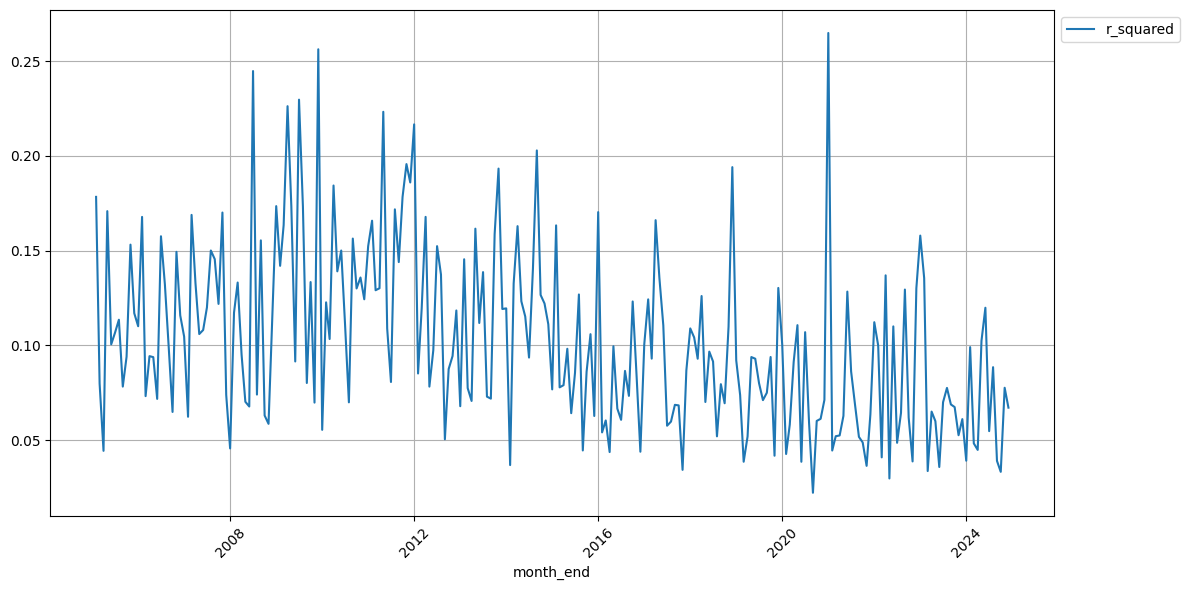

In [11]:
#calc summary stats gives us 
print(calc_summary_regression_stats(regression_stats).head().to_markdown(index=False))
#regression_stats = regression_stats.sort_values(by='month_end')
time_series_df_plot(regression_stats, 'month_end', ['r_squared'])

## Show Summary for Coefficients

In [12]:
summary = calc_summary_coefficients(coefficients, sort_order = independent_variables)
# summary["variable"] = summary["variable"].str[:20]
print(summary.to_markdown(index=False))

| variable                    |    avg_ceoff |     stdev |    Sharpe |   avg_p_value |   perc_below_0.05 |
|:----------------------------|-------------:|----------:|----------:|--------------:|------------------:|
| const                       | -0.0146951   | 0.0892836 | 0.16459   |     0.0848305 |         0.790795  |
| quality                     |  0.00557942  | 0.0201718 | 0.276595  |     0.45947   |         0.100418  |
| value                       |  0.00796599  | 0.0277465 | 0.287098  |     0.388593  |         0.142259  |
| coverage                    |  0.00525916  | 0.0197939 | 0.265696  |     0.479143  |         0.0334728 |
| momentum                    |  0.00105697  | 0.0224111 | 0.0471627 |     0.449987  |         0.112971  |
| size                        |  0.0044316   | 0.0276144 | 0.160481  |     0.396285  |         0.154812  |
| earnings_volatility         | -0.00153096  | 0.0172502 | 0.08875   |     0.484865  |         0.0627615 |
| growth                      | -0.00

## Graph Cumulative Coefficients

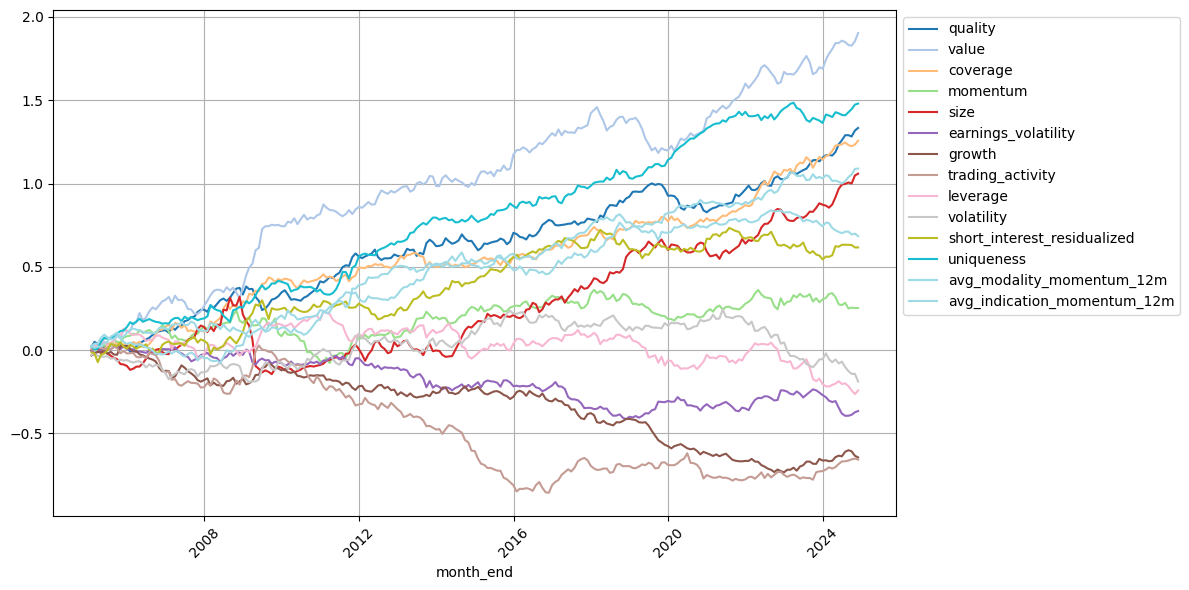

In [13]:
cumulative_ceoff = calculate_cumulative_coefficients(coefficients_pivot, 'month_end')
time_series_df_plot(cumulative_ceoff, 'month_end', financial_factors + ["uniqueness"] + [mod_ind_momentum_factors])

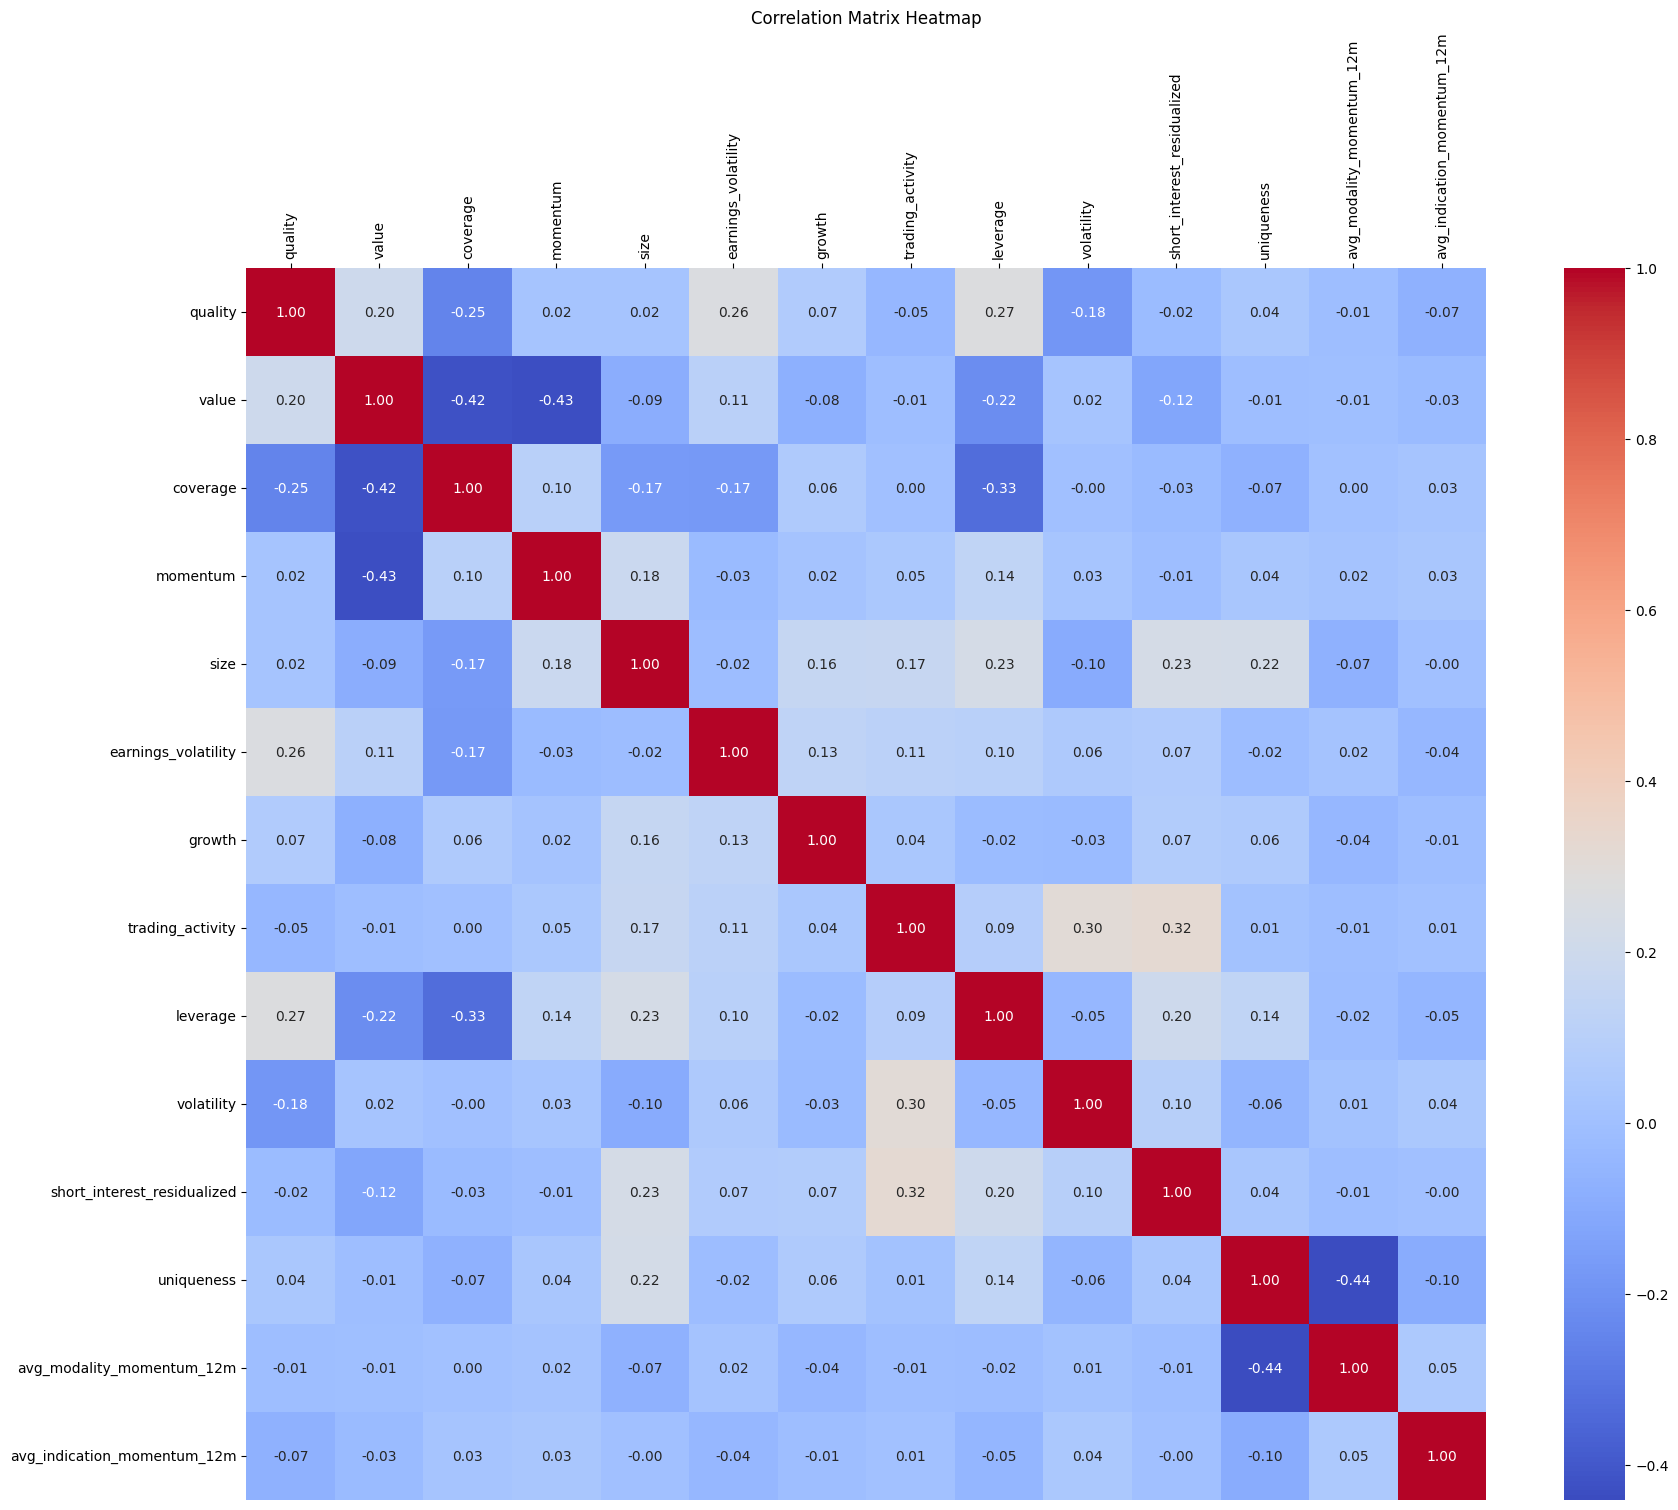

In [14]:
correlation_table(z_scored_data, financial_factors + ["uniqueness"] + mod_ind_momentum_factors)